In [ ]:
#TODO: Writeup with linking to code
#What is better to use after SVM? Poly or RBF Kernel?

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Vis import ClassificationVis
from Evals import *
from Data_Provider import *
from Util import ClassificationUtils as util

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

/home/emil/miniconda3/envs/emocog/lib/python3.7/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')


In [4]:
#important configs
sliding = 10
wsize = 100
s_sample = 0
e_sample = 9000
s_sample_ev = 9000
e_sample_ev = 12500


#x,y,x_ev,y_ev = get_data(wsize=wsize,sliding=sliding,s_sample=s_sample,e_sample=e_sample, s_sample_ev=s_sample_ev, e_sample_ev=e_sample_ev)
#save_data_to_file(x,y,x_ev,y_ev,wsize=wsize,sliding=sliding,s_sample=s_sample,e_sample=e_sample, s_sample_ev=s_sample_ev, e_sample_ev=e_sample_ev)

x,y,x_ev,y_ev = get_data_from_file(wsize=wsize,sliding=sliding,s_sample=s_sample,e_sample=e_sample, s_sample_ev=s_sample_ev, e_sample_ev=e_sample_ev)
print(x.shape)
print(y.shape)
print(x_ev.shape)

(669, 44)
(669,)
(148, 44)


In [5]:
print(np.unique(y,return_counts=True))
print(np.unique(y_ev,return_counts=True))

(array([0., 1.]), array([478, 191]))
(array([0., 1.]), array([110,  38]))


In [14]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,random_state=1)
results_df = pd.DataFrame(columns=('C','Gamma','Degree','Threshold','F1 Score Tr','Precision Tr','Recall Tr','F1 Score Ev','Precision Ev','Recall Ev'))
degree=np.random.choice(np.arange(10)[1:],5)
cs = np.random.uniform(0,4,5)
gammas = 2**(np.random.choice(18,5)-15.)
for idx,(deg,c,g) in enumerate(zip(degree,cs,gammas)):
    classifier = svm.SVC(C=c,kernel='poly', probability = True,gamma =g,degree=deg,random_state=5)
    thresh = util.get_optimal_threshold(classifier, cv, x, y) # get threshold using cv
    y_pred,y_pred_ev = util.fit_predict(classifier, x, y, x_ev, y_ev, thresh) # using that threshold, get predictions and f1 score
    f1_tr=get_f1(y_pred,y) # calculate f1 scores for prediction on train set
    f1_ev=get_f1(y_pred_ev,y_ev)
    prec_tr,recall_tr = get_precision_recall(y_pred,y)
    prec_ev,recall_ev = get_precision_recall(y_pred_ev,y_ev)
    results_df.loc[idx] = [c,g,deg,thresh,f1_tr,prec_tr,recall_tr,f1_ev,prec_ev,recall_ev]
    print('Gamma = %.6f, Dim = %d, C= %.2f F1 on train: %.4f, F1 on Ev: %.4f' %(g,deg,c,f1_tr,f1_ev))

Gamma = 0.015625, Dim = 2, C= 2.94 F1 on train: 0.9791, F1 on Ev: 0.2961
Gamma = 0.125000, Dim = 6, C= 3.39 F1 on train: 0.7873, F1 on Ev: 0.0000
Gamma = 0.062500, Dim = 3, C= 1.13 F1 on train: 0.6209, F1 on Ev: 0.3289
Gamma = 0.000977, Dim = 1, C= 1.66 F1 on train: 0.6893, F1 on Ev: 0.4355
Gamma = 0.250000, Dim = 1, C= 3.86 F1 on train: 0.8284, F1 on Ev: 0.3762


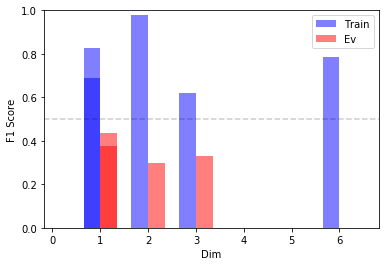

In [15]:
#bar_plot_svc(scores_tr,scores_ev,hypers,threshs) #with thresholds
ClassificationVis.bar_plot_svc(results_df['F1 Score Tr'],results_df['F1 Score Ev'],degree) #without thresholds

In [16]:
best_choice = util.get_best_hyperparas_results(results_df) #what were the best hyperparas?
print(best_choice)
best_c,best_g,best_d,best_thr =best_choice[:4]

C               1.659106
Gamma           0.000977
Degree          1.000000
Threshold       0.326744
F1 Score Tr     0.689266
Precision Tr    0.748466
Recall Tr       0.638743
F1 Score Ev     0.435484
Precision Ev    0.313953
Recall Ev       0.710526
Name: 3, dtype: float64


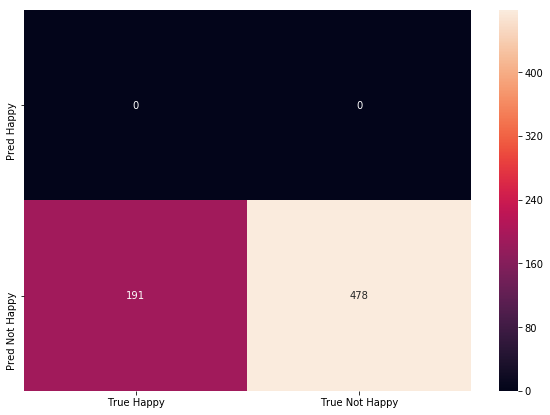

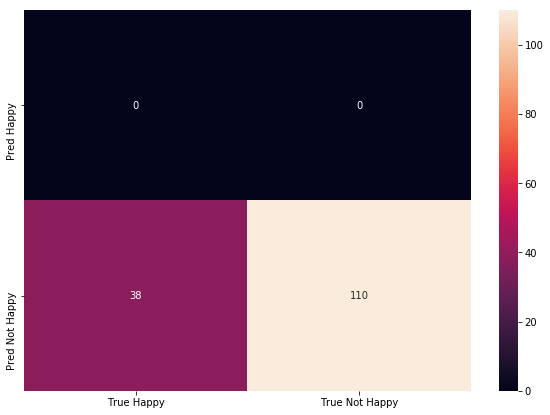

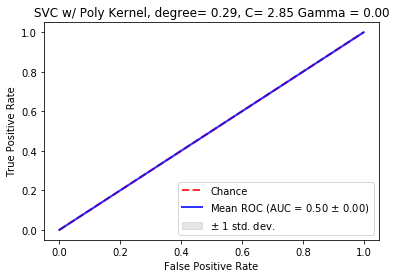

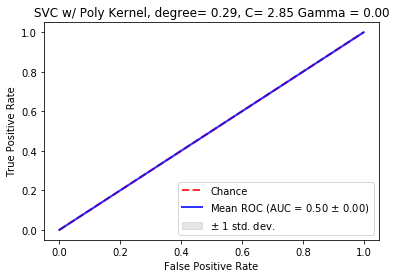

In [29]:
#get the conf matrices
classifier = svm.SVC(C=best_c,kernel='poly', probability=True,degree=best_d,gamma=best_g,random_state=5)
y_pred,y_pred_ev = util.fit_predict(classifier, x, y, x_ev, y_ev, best_thr)
get_conf_mat(y_pred,y)
get_conf_mat(y_pred_ev,y_ev)
plt.show()
ClassificationVis.plot_roc(x,y,svm.SVC(C=best_c, kernel='poly', probability=True,degree=best_d,gamma = best_g,random_state=5), 'SVC w/ Poly Kernel, degree= {:.2f}, C= {:.2f} Gamma = {:.2f}'.format(best_d,best_c, best_g))
ClassificationVis.plot_roc(x_ev,y_ev,svm.SVC(C=best_c, kernel='poly', probability=True,degree=best_d,gamma = best_g,random_state=5), 'SVC w/ Poly Kernel, degree= {:.2f}, C= {:.2f} Gamma = {:.2f}'.format(best_d,best_c, best_g))

In [23]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,random_state=0)
scores_tr = []
scores_ev = []
threshs = []
results_df = pd.DataFrame(columns=('C','Gamma','Threshold','F1 Score Tr','Precision Tr','Recall Tr','F1 Score Ev','Precision Ev','Recall Ev'))
cs = np.random.uniform(0,5,10)
gammas = 2**(np.random.choice(18,10)-15.)
for idx,(g,c) in enumerate(zip(gammas,cs)):
    classifier = svm.SVC(C=c,kernel='rbf', probability = True,gamma = g, random_state=5)
    thresh = util.get_optimal_threshold(classifier, cv, x, y) # get threshold using cv
    y_pred,y_pred_ev = util.fit_predict(classifier, x, y, x_ev, y_ev, thresh) # using that threshold, get predictions and f1 score
    f1_tr=get_f1(y_pred,y) # calculate f1 scores for prediction on train set
    f1_ev=get_f1(y_pred_ev,y_ev)
    prec_tr,recall_tr = get_precision_recall(y_pred,y)
    prec_ev,recall_ev = get_precision_recall(y_pred_ev,y_ev)
    results_df.loc[idx] = [c,g,thresh,f1_tr,prec_tr,recall_tr,f1_ev,prec_ev,recall_ev]
    print('Gamma = %.6f, C= %2.2f, F1 on train: %.4f, F1 on Ev: %.4f' % (g,c,f1_tr,f1_ev))
    

Gamma = 1.000000, C= 0.85, F1 on train: 1.0000, F1 on Ev: 0.4086
Gamma = 0.003906, C= 3.82, F1 on train: 0.9454, F1 on Ev: 0.0000
Gamma = 0.000977, C= 1.14, F1 on train: 0.8019, F1 on Ev: 0.3825
Gamma = 0.015625, C= 4.61, F1 on train: 0.9870, F1 on Ev: 0.3069
Gamma = 4.000000, C= 4.45, F1 on train: 0.0000, F1 on Ev: 0.4086
Gamma = 0.001953, C= 2.52, F1 on train: 0.8889, F1 on Ev: 0.2078
Gamma = 0.000244, C= 2.85, F1 on train: 0.7178, F1 on Ev: 0.4561
Gamma = 0.500000, C= 2.71, F1 on train: 1.0000, F1 on Ev: 0.4086
Gamma = 0.007812, C= 3.32, F1 on train: 0.9614, F1 on Ev: 0.1842
Gamma = 2.000000, C= 2.54, F1 on train: 1.0000, F1 on Ev: 0.4086


In [27]:
#ClassificationVis.plot_svc(scores_tr,scores_ev,cs,label='C')
#get best hyperpara
best_choice = util.get_best_hyperparas_results(results_df) #what were the best hyperparas?
print(best_choice)
best_c,best_g,best_thr =best_choice[:3]

C               2.845896
Gamma           0.000244
Threshold       0.286152
F1 Score Tr     0.717808
Precision Tr    0.752874
Recall Tr       0.685864
F1 Score Ev     0.456140
Precision Ev    0.342105
Recall Ev       0.684211
Name: 6, dtype: float64


Precision recall on train (0.7528735632183908, 0.6858638743455497)
Precision recall on ev (0.34210526315789475, 0.6842105263157895)


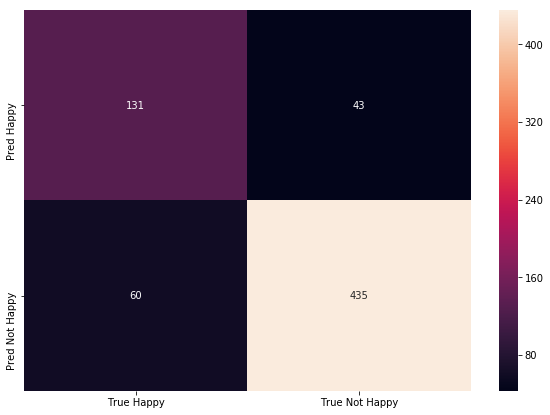

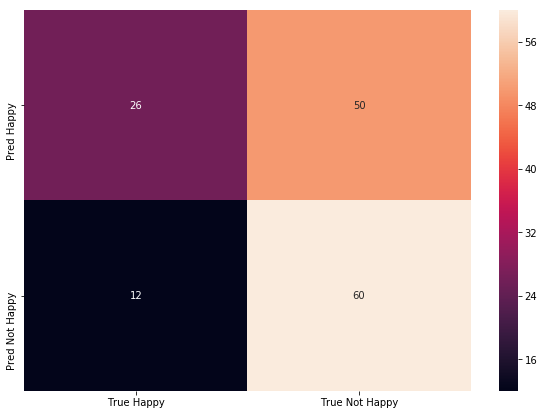

In [28]:
#get f1 scores on whole training set
classifier = svm.SVC(C=best_c, kernel='rbf', probability=True,gamma = best_g,random_state=5)
y_pred,y_pred_ev = util.fit_predict(classifier, x, y, x_ev, y_ev, best_thr)
get_conf_mat(y_pred,y)
get_conf_mat(y_pred_ev,y_ev)
plt.show()
get_conf_mat(y_pred,y)
get_conf_mat(y_pred_ev,y_ev)

In [ ]:
ClassificationVis.plot_roc(x,y,svm.SVC(C=best_c, kernel='rbf', probability=True,gamma = best_g,random_state=5), 'SVC, RBF Kernel, C ={:.2f}, Gamma = {:.5f}'.format(best_c,best_g))
ClassificationVis.plot_roc(x_ev,y_ev,svm.SVC(C=best_c, kernel='rbf', probability=True,gamma = best_g,random_state=5), 'SVC, RBF Kernel, C ={:.2f}, Gamma = {:.5f}'.format(best_c,best_g))

In [31]:
#first try random forest:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,random_state=0)
results_df = pd.DataFrame(columns=('Number Estimators','Max Depth','Max Features','Threshold','F1 Score Tr','Precision Tr','Recall Tr','F1 Score Ev','Precision Ev','Recall Ev'))
est = np.random.choice(np.arange(130)[5:],35)
max_d = np.random.choice(np.arange(60)[1:],35)
max_f = np.random.choice(np.arange(min(x.shape))[1:],35)

for idx,(c,d,f) in enumerate(zip(est,max_d,max_f)):
    classifier = RandomForestClassifier(n_estimators=c, max_depth=d, max_features=f,
                              random_state=0)
    thresh = util.get_optimal_threshold(classifier, cv, x, y) # get threshold using cv
    y_pred,y_pred_ev = util.fit_predict(classifier, x, y, x_ev, y_ev, thresh) # using that threshold, get predictions and f1 score
    f1_tr=get_f1(y_pred,y) # calculate f1 scores for prediction on train set
    f1_ev=get_f1(y_pred_ev,y_ev)
    prec_tr,recall_tr = get_precision_recall(y_pred,y)
    prec_ev,recall_ev = get_precision_recall(y_pred_ev,y_ev)
    results_df.loc[idx] = [c,d,f,thresh,f1_tr,prec_tr,recall_tr,f1_ev,prec_ev,recall_ev]
    print('Number Estimators= %d, Max Depth = %d, Max Feat = %d, F1 on train: %.4f, F1 on Ev: %.4f' % (c,d,f,f1_tr,f1_ev))
    


Number Estimators= 45, Max Depth = 53, Max Feat = 40, F1 on train: 1.0000, F1 on Ev: 0.1093
Number Estimators= 8, Max Depth = 26, Max Feat = 4, F1 on train: 0.9894, F1 on Ev: 0.0140
Number Estimators= 10, Max Depth = 32, Max Feat = 39, F1 on train: 0.9563, F1 on Ev: 0.0035
Number Estimators= 43, Max Depth = 40, Max Feat = 18, F1 on train: 1.0000, F1 on Ev: 0.0991
Number Estimators= 114, Max Depth = 20, Max Feat = 24, F1 on train: 1.0000, F1 on Ev: 0.0557
Number Estimators= 122, Max Depth = 47, Max Feat = 9, F1 on train: 1.0000, F1 on Ev: 0.1316
Number Estimators= 24, Max Depth = 27, Max Feat = 9, F1 on train: 0.9867, F1 on Ev: 0.0000
Number Estimators= 100, Max Depth = 5, Max Feat = 38, F1 on train: 0.9521, F1 on Ev: 0.1115
Number Estimators= 14, Max Depth = 36, Max Feat = 26, F1 on train: 0.9947, F1 on Ev: 0.0066
Number Estimators= 108, Max Depth = 25, Max Feat = 7, F1 on train: 0.9813, F1 on Ev: 0.0000
Number Estimators= 22, Max Depth = 34, Max Feat = 36, F1 on train: 0.9974, F1 on E

Number Estimators    38.000000
Max Depth            42.000000
Max Features         14.000000
Threshold             0.394737
F1 Score Tr           1.000000
Precision Tr          1.000000
Recall Tr             1.000000
F1 Score Ev           0.204836
Precision Ev          0.324324
Recall Ev             0.315789
Name: 19, dtype: float64


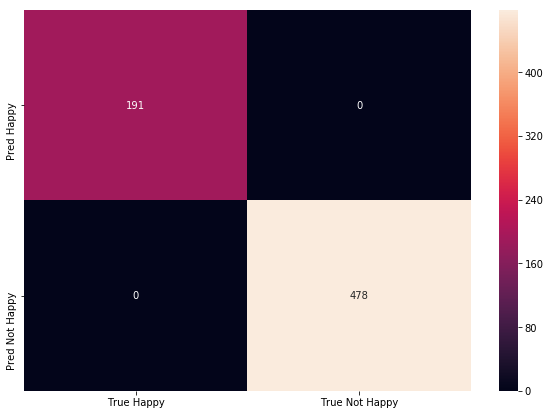

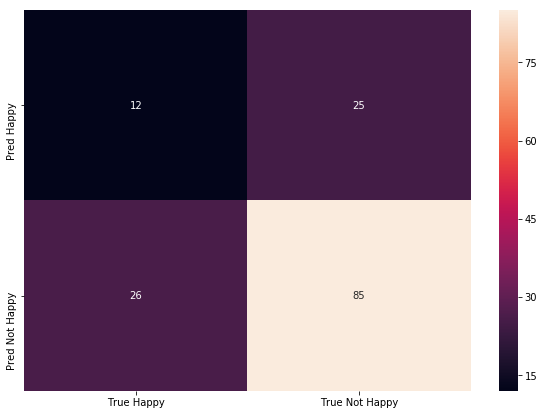

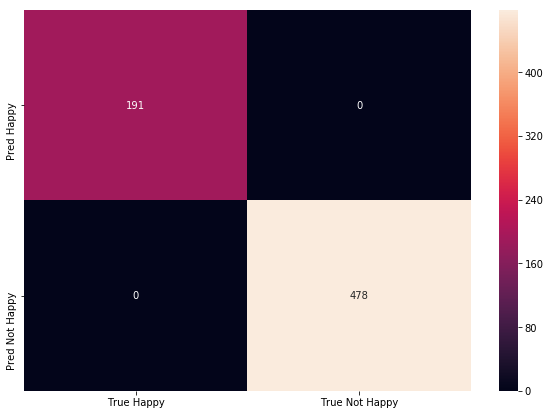

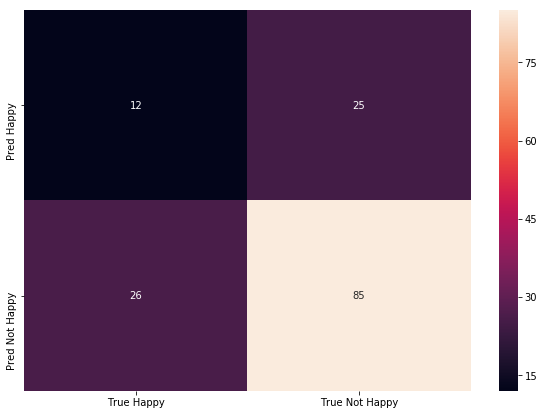

In [34]:
#get best hyperpara
best_choice = util.get_best_hyperparas_results(results_df) #what were the best hyperparas?
print(best_choice)
best_n,best_d,best_f,best_thr =best_choice[:4]
#get f1 scores on whole training set

classifier = RandomForestClassifier(n_estimators=int(best_n), max_depth=int(best_d), max_features=int(best_f),
                              random_state=0)
y_pred,y_pred_ev = util.fit_predict(classifier, x, y, x_ev, y_ev, best_thr)
get_conf_mat(y_pred,y)
get_conf_mat(y_pred_ev,y_ev)
plt.show()
get_conf_mat(y_pred,y)
get_conf_mat(y_pred_ev,y_ev)

In [ ]:
ClassificationVis.plot_roc(x,y,RandomForestClassifier(n_estimators=best_n, max_depth=best_d, max_features=best_f,
                              random_state=0), 'Random Forest, n_estimators = {:d}, max_depth={:d}, max_features = {:d}'.format(best_n,best_d,best_f))
ClassificationVis.plot_roc(x_ev,y_ev,RandomForestClassifier(n_estimators=best_n, max_depth=best_d, max_features=best_f,
                              random_state=0), 'Random Forest, n_estimators = {:d}, max_depth={:d}, max_features = {:d}'.format(best_n,best_d,best_f))